In [29]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score,calinski_harabasz_score,davies_bouldin_score
from pprint import pprint
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=True

In [3]:
# 加载数据 - 只要没有进行插值
data = []
feature_method = ['CHI','IG','MI']
is_inter = ['False']
for f in feature_method:
    for inter in is_inter:
        data.append(np.load('./np_cluster/np_{}_{}.npy'.format(f,inter)))

In [5]:
# 去除数据中的最后一列，获得用于聚类的数据
def split_data(data):
    return data[:,0:-1]

In [7]:
code = {
    0:'CHI(without Interpolation)',
    1:'IG(without Interpolation)',
    2:'MI(without Interpolation)',
}
code_component = {
    0:10,
    1:10,
    2:4,
}
score = {}
for idx,data_item in enumerate(data):
    print('-----{}-----'.format(idx))
    cluster_data = split_data(data_item)
    print('cluster_data:{}'.format(cluster_data.shape))
    score[code[idx]] = {}
    # 没有PCA
    score[code[idx]]['Kmeans'] = {}
    model = KMeans(n_clusters=3,init='k-means++',max_iter=4000).fit(cluster_data)
    score[code[idx]]['Kmeans']['SC'] = silhouette_score(cluster_data,model.labels_)
    score[code[idx]]['Kmeans']['CH'] = calinski_harabasz_score(cluster_data,model.labels_)
    score[code[idx]]['Kmeans']['DB'] = davies_bouldin_score(cluster_data,model.labels_)
    # 有PCA
    score[code[idx]]['Kmeans(PCA)'] = {}
    pca = PCA(n_components=code_component[idx])
    cluster_data_pca = pca.fit_transform(cluster_data)
    model_pca = KMeans(n_clusters=3,init='k-means++',max_iter=4000).fit(cluster_data_pca)
    score[code[idx]]['Kmeans(PCA)']['SC'] = silhouette_score(cluster_data_pca,model_pca.labels_)
    score[code[idx]]['Kmeans(PCA)']['CH'] = calinski_harabasz_score(cluster_data_pca,model_pca.labels_)
    score[code[idx]]['Kmeans(PCA)']['DB'] = davies_bouldin_score(cluster_data_pca,model_pca.labels_)
pprint(score)

-----0-----
cluster_data:(3583, 94)
-----1-----
cluster_data:(3583, 94)
-----2-----
cluster_data:(3205, 94)
{'CHI(without Interpolation)': {'Kmeans': {'CH': 1437.6503133218812,
                                           'DB': 0.9813989329624423,
                                           'SC': 0.2819287231759258},
                                'Kmeans(PCA)': {'CH': 2162.898328599922,
                                                'DB': 0.7781630248240466,
                                                'SC': 0.36699103603571864}},
 'IG(without Interpolation)': {'Kmeans': {'CH': 1419.1236860581314,
                                          'DB': 0.9874181431588238,
                                          'SC': 0.2801131567788706},
                               'Kmeans(PCA)': {'CH': 2142.126250581716,
                                               'DB': 0.7818478061577002,
                                               'SC': 0.36552141192077936}},
 'MI(without Interpolation)': {'Km

In [42]:
np.save('./np_cluster/score.npy',score)

In [12]:
# final聚类模型
cluster_data = data[2]
pca = PCA(n_components=4)
cluster_data_pca = pca.fit_transform(split_data(cluster_data))
model_pca = KMeans(n_clusters=3,init='k-means++',max_iter=4000).fit(cluster_data_pca)

In [15]:
labels = model_pca.labels_

In [17]:
true_label = cluster_data[:,-1]

In [16]:
len(labels)

3205

In [18]:
len(true_label)

3205

In [21]:
cluster_count = {}
for department in range(1,14,1):
    cluster_count[department] = {}
    for cluster_num in range(0,3,1):
        cluster_count[department][cluster_num] = 0
for idx,department in enumerate(true_label):
    cluster_count[department][labels[idx]] += 1

In [28]:
# 病区编码
coder = {
    1:'口腔科病区',
    2:'妇产科病区',
    3:'心血管病区',
    4:'整形外科病区',
    5:'普通外科病区',
    6:'普通胸外科病区',
    7:'泌尿外科中心病区',
    8:'眼科病区',
    9:'神经内科病区',
    10:'神经外科病区',
    11:'耳鼻咽喉科病区',
    12:'肝胆外科病区',
    13:'骨科病区'
}

In [40]:

def cal_dist(department_num1,department_num2):
    total = 0
    same = 0
    for i in range(3):
        total += cluster_count[department_num1][i] + cluster_count[department_num2][i]
        same += min(cluster_count[department_num1][i],cluster_count[department_num2][i])
    return round(2*same / total,4)

def gen_department_dist_matrix():
    department_list = [name for _,name in coder.items()]
    matrix = pd.DataFrame(index=department_list,columns=department_list)
    for i in range(1,14,1):
        for j in range(1,14,1):
            matrix.loc[coder[i],coder[j]] = cal_dist(i,j)
    return matrix

In [43]:
dist_mat = gen_department_dist_matrix()

In [44]:
dist_mat.to_excel('./np_cluster/deparment_dist.xlsx')

In [39]:
cal_dist(1,2)

0.2592

In [22]:
pprint(cluster_count)

{1: {0: 68, 1: 20, 2: 0},
 2: {0: 442, 1: 149, 2: 0},
 3: {0: 133, 1: 219, 2: 0},
 4: {0: 12, 1: 8, 2: 0},
 5: {0: 209, 1: 106, 2: 0},
 6: {0: 139, 1: 52, 2: 0},
 7: {0: 322, 1: 95, 2: 0},
 8: {0: 16, 1: 5, 2: 0},
 9: {0: 27, 1: 31, 2: 0},
 10: {0: 146, 1: 141, 2: 0},
 11: {0: 182, 1: 30, 2: 1},
 12: {0: 120, 1: 114, 2: 0},
 13: {0: 252, 1: 166, 2: 0}}


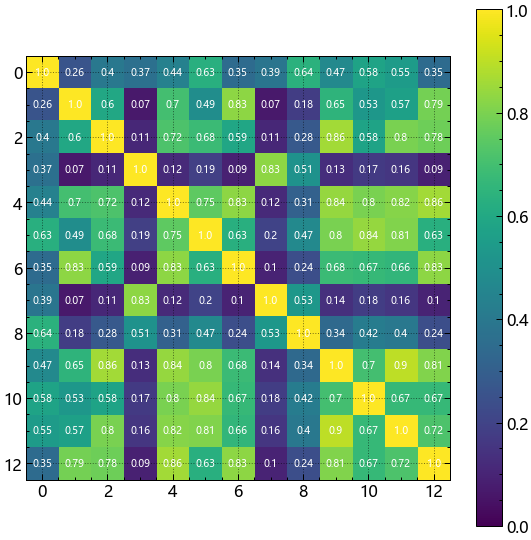

In [63]:
with plt.style.context(['science','grid','notebook']):
    map_data = dist_mat.values.astype(float)
    map_data = np.around(map_data,2)
#     plt.figure(figsize=(7.5,5.5),dpi=100)
    fig,ax = plt.subplots(figsize=(9.5,9.5))
    plt.imshow(map_data,vmin=0.0,vmax=1.0)
    for i in range(13):
        for j in range(13):
            text = ax.text(j,i,map_data[i,j],ha="center", va="center", color="w")
    plt.colorbar()
    plt.show()

In [48]:
dist_mat.values.dtype

dtype('O')